# <h1><center>TP2 - Visión por computadora - CEIA</center></h1>

In [20]:
# Importaciones
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from typing import Callable
from matplotlib import colors
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

<center>

<img src="./resources/portada.jpeg" width="600" alt="Figura 1: A person applying a sharpness filter, in the spectral domain, on an image inside a computer. The person is a scientist expert in computer vision - Generada con Microsoft Image Creator">

<small><em>Figura 1: A person applying a sharpness filter, in the spectral domain, on an image inside a computer. The person is a scientist expert in computer vision - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<em>Datos del proyecto:</em>

| Subtitulo       | TP2 - Visión por computadora - FIUBA                                                                                                   |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Análisis de enfoque en el dominio espectral                                                                                            |
| **Integrantes** | • Bruno Masoller (brunomaso1@gmail.com)                                                                                                |

</center>

## Consinga

![Consinga](.\resources\Consigna.PNG)

![Ejemplo](.\resources\Ejemplo1.PNG)

## Parte 1

> Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las  cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

> Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
> 1. Medición sobre todo el frame.
> 2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
> 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3)
 
> Para cada experimento se debe presentar :
> - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
> - Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

*Métrica del paper: Image Sharpness Measure for Blurred Images in Frequency Domain*

*Como resumen, el algorimto que se propone es el siguiente:*
```
Input: Image I of size MxN
Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure 
Step 1: Compute F which is the Fourier Transform representation of image I   
Step 2: Find Fc which is obtained by shifting the origin of F to centre.
Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I. 
Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F. 
Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000. 
Step 6: Calculate Image Quality measure (FM) from equation: Image Quality Measure (FM) = TH/(MxN)
```

In [29]:
def kanjar_fdibm(image: np.ndarray) -> float:
    # Pasamos la imagen a negro
    img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Hacemos la transformada y centramos con estas lineas mágicas.
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    
    # Obtenemos los valores absolutos de todos los coeficientes.
    abs_values = np.abs(img_fft)
    
    # Obtenemos el máximo de los coeficientes.
    maximum_value = np.max(abs_values)
    
    # Calculamos los pixeles totales que fueron mayores al threeshold maximun_value/1000
    T_H = abs_values[abs_values > (maximum_value / 1000)].size
    
    # Finalmente retornamos la métrica    
    return T_H/img.size

*Probamos la métrica con una imagen:*

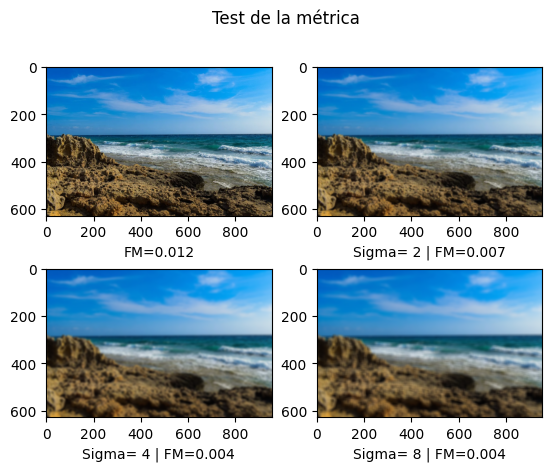

In [45]:
img = cv.imread('./resources/segmentacion.png')

plt.suptitle('Test de la métrica')

plt.subplot(221)
plt.imshow(img[:, :, ::-1])
plt.xlabel(f'FM={kanjar_fdibm(img):.3f}')

sigma = 2
plt.subplot(222)
plt.imshow(cv.GaussianBlur(img, (15, 15), sigma)[:, :, ::-1])
plt.xlabel(f'Sigma= {sigma} | FM={kanjar_fdibm(cv.GaussianBlur(img, (15, 15), sigma)):.3f}')

plt.show()

### Experimento 1

In [60]:
# Configuración y parámetros
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)
FDIBM_THRESHOLD = 0.04

In [ ]:
def do_eperiment(video_path: str, ROI: np.ndarray = None, sparse_matrix: np.ndarray = None) -> None:
    # Abre el video
    video_path = './resources/focus_video.mov'
    captura_video = cv.VideoCapture(video_path)

    fms = []
    colors = []

    if not captura_video.isOpened():
        raise IOError("Error al abrir el archivo de video")
    else:
        # Obtener las dimensiones del video
        frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
        frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

        # Tamaño del video
        original_size = (frame_width, frame_height)

        # Obtén la tasa de cuadros (frame rate) del video
        fps = int(captura_video.get(cv.CAP_PROP_FPS))
        delay = int(1000 / fps)

        while True:
            ret, frame = captura_video.read()
            if not ret:
                break

            result = frame.copy()

            bbox_start = (1, 1)
            bbox_end = (frame_width-1, frame_height-1)

            fm = kanjar_fdibm(result)
            fms.append(fm)

            if fm >= FDIBM_THRESHOLD:
                cv.rectangle(result, bbox_start, bbox_end, COLOR_GREEN, 2)
                colors.append('g')
            else:
                cv.rectangle(result, bbox_start, bbox_end, COLOR_RED, 2)
                colors.append('r')

            # Crear la gráfica de los valores de fms con los colores respectivos
            # Crea una nueva figura y un conjunto de ejes.
            fig, ax = plt.subplots()

            # Crea un scatter plot de los valores de `fms`.
            # `range(len(fms))` proporciona los valores x (índices de los elementos en `fms`).
            # `fms` proporciona los valores y (valores reales almacenados en `fms`).
            # `c=colors` define los colores de los puntos en el scatter plot.
            ax.scatter(range(len(fms)), fms, c=colors)

            # Crea un objeto `FigureCanvas` a partir de la figura `fig`.
            canvas = FigureCanvas(fig)

            # Dibuja la figura en el canvas para que se renderice.
            canvas.draw()

            # Convierte el contenido del canvas a un arreglo de NumPy usando el buffer RGBA.
            graph_image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')

            # Redimensiona el arreglo de NumPy a las dimensiones correctas.
            # `canvas.get_width_height()[::-1]` proporciona las dimensiones de la imagen (anchura, altura).
            # `+ (4,)` añade el canal de color (RGBA).
            graph_image = graph_image.reshape(canvas.get_width_height()[
                                            ::-1] + (4,))  # (H, W, 4)

            # Convierte la imagen de formato RGBA a formato BGR, que es el formato de color esperado por OpenCV.
            graph_image = cv.cvtColor(graph_image, cv.COLOR_RGBA2BGR)

            # Redimensiona la imagen del gráfico para que coincida con el tamaño del frame del video.
            graph_image = cv.resize(graph_image, (frame_width, frame_height))

            # Combina el frame original y la imagen del gráfico lado a lado
            frame_combined = np.hstack((result, graph_image))

            # Mostrar el frame combinado
            cv.imshow('Video Enfocado', frame_combined)

            # Cerrar la figura para evitar consumir demasiada memoria
            plt.close(fig)

            # Salir del loop si se presiona la tecla 'q'
            if cv.waitKey(delay) & 0xFF == ord('q'):
                break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

In [81]:
# Abre el video
video_path = './resources/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

fms = []
colors = []

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

    # Tamaño del video
    original_size = (frame_width, frame_height)

    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    delay = int(1000 / fps)

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        result = frame.copy()

        bbox_start = (1, 1)
        bbox_end = (frame_width-1, frame_height-1)

        fm = kanjar_fdibm(result)
        fms.append(fm)

        if fm >= FDIBM_THRESHOLD:
            cv.rectangle(result, bbox_start, bbox_end, COLOR_GREEN, 2)
            colors.append('g')
        else:
            cv.rectangle(result, bbox_start, bbox_end, COLOR_RED, 2)
            colors.append('r')

        # Crear la gráfica de los valores de fms con los colores respectivos
        # Crea una nueva figura y un conjunto de ejes.
        fig, ax = plt.subplots()

        # Crea un scatter plot de los valores de `fms`.
        # `range(len(fms))` proporciona los valores x (índices de los elementos en `fms`).
        # `fms` proporciona los valores y (valores reales almacenados en `fms`).
        # `c=colors` define los colores de los puntos en el scatter plot.
        ax.scatter(range(len(fms)), fms, c=colors)

        # Crea un objeto `FigureCanvas` a partir de la figura `fig`.
        canvas = FigureCanvas(fig)

        # Dibuja la figura en el canvas para que se renderice.
        canvas.draw()

        # Convierte el contenido del canvas a un arreglo de NumPy usando el buffer RGBA.
        graph_image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')

        # Redimensiona el arreglo de NumPy a las dimensiones correctas.
        # `canvas.get_width_height()[::-1]` proporciona las dimensiones de la imagen (anchura, altura).
        # `+ (4,)` añade el canal de color (RGBA).
        graph_image = graph_image.reshape(canvas.get_width_height()[
                                          ::-1] + (4,))  # (H, W, 4)

        # Convierte la imagen de formato RGBA a formato BGR, que es el formato de color esperado por OpenCV.
        graph_image = cv.cvtColor(graph_image, cv.COLOR_RGBA2BGR)

        # Redimensiona la imagen del gráfico para que coincida con el tamaño del frame del video.
        graph_image = cv.resize(graph_image, (frame_width, frame_height))

        # Combina el frame original y la imagen del gráfico lado a lado
        frame_combined = np.hstack((result, graph_image))

        # Mostrar el frame combinado
        cv.imshow('Video Enfocado', frame_combined)

        # Cerrar la figura para evitar consumir demasiada memoria
        plt.close(fig)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

*Graficamos los valores de la métrica:*

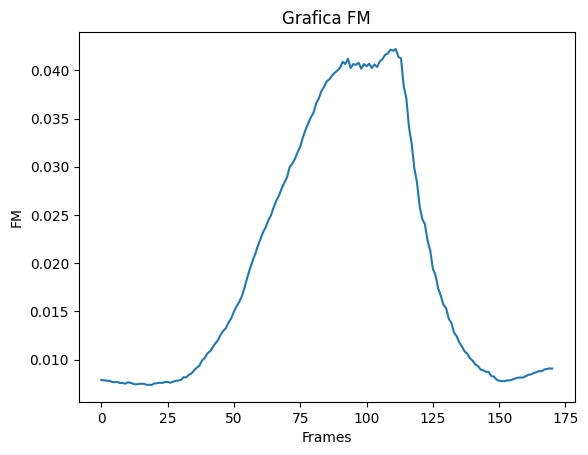

In [78]:
plt.figure()
plt.plot(fms)
plt.title('Grafica FM')
plt.xlabel('Frames')
plt.ylabel('FM')
plt.show()

### Experimento 2